In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import sys
sys.path.append('../src')
from data.audio_dataset import AudioSpectrogramDataset
from models.PGAN_model.PGAN import PGAN
from models.PGAN_model.config import *

import torch
import librosa
import soundfile as sf
from torch.utils.data import DataLoader

In [50]:
dataset = AudioSpectrogramDataset(base_directory=base_directory, spectro_type='mel')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [8]:
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# import random

# manualSeed = 999
# #manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)
# # torch.use_deterministic_algorithms(True) # Needed for reproducible results

# image_size = 64
# # learning_rate = 0.0002
# # learning_rate = 0.00005

# dataroot = "../data/raw/celeba3/"

# dataset = dset.ImageFolder(root=dataroot,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))

# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                          shuffle=True, num_workers=2)

Random Seed:  999


In [9]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torchvision.utils as vutils

In [ ]:
# device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# # Plot some training images
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [51]:
Music_PGAN = PGAN(
    latent_dim=latent_dim,
    output_dim=output_dim,
    lr=learning_rate,
    loss=loss,
    batch_size=batch_size,
    gpu=gpu,
    depths=depths, 
    negative_slope=negative_slope,
    fade_in_percentage=fade_in_percentage,
    save_interval=save_interval,
    normalization=normalization,
    mini_batch_normalization=mini_batch_normalization,
    gen_type=get_type,
    init_resolution_size=init_resolution_size,
    num_epochs_per_resolution=num_epochs_per_resolution,
    gen_output_dim=gen_output_dim,
)

In [52]:
Music_PGAN.train(dataloader=dataloader)

Resolution 0 - Epoch 1/10 - D Loss: 1.378824234008789 - G Loss: 3.064020872116089
Resolution 0 - Epoch 2/10 - D Loss: 2.9911999702453613 - G Loss: 1.1920928244535389e-07
Resolution 0 - Epoch 3/10 - D Loss: 12.239285469055176 - G Loss: 29.749305725097656
Resolution 0 - Epoch 4/10 - D Loss: 29.47641372680664 - G Loss: 0.022487521171569824
Resolution 0 - Epoch 5/10 - D Loss: 0.05584234371781349 - G Loss: 0.01934635452926159
Resolution 0 - Epoch 6/10 - D Loss: 0.010836746543645859 - G Loss: 0.018720725551247597
Resolution 0 - Epoch 7/10 - D Loss: 0.00617188960313797 - G Loss: 0.0047410218976438046
Resolution 0 - Epoch 8/10 - D Loss: 0.1387471854686737 - G Loss: 0.0
Resolution 0 - Epoch 9/10 - D Loss: 0.058173369616270065 - G Loss: 0.0
Resolution 0 - Epoch 10/10 - D Loss: 0.000488094927277416 - G Loss: 0.0
Resolution 1 - Epoch 1/10 - D Loss: 0.013971136882901192 - G Loss: 0.0
Resolution 1 - Epoch 2/10 - D Loss: 13.414758682250977 - G Loss: 3.3689191341400146
Resolution 1 - Epoch 3/10 - D Lo

In [6]:
checkpoint_path = "../src/models/PGAN_model/checkpoints/PGAN_checkpoint_res1_epoch4.pth"
Music_PGAN.train(dataloader=dataloader, checkpoint_path=checkpoint_path)

Resuming training from epoch 4 at resolution 1
Resolution 1 - Epoch 5/10 - D Loss: 0.26160770654678345 - G Loss: 0.7603479027748108
Resolution 1 - Epoch 6/10 - D Loss: 0.2303144931793213 - G Loss: 0.5080401301383972
Checkpoint saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\PGAN_model\checkpoints\PGAN_checkpoint_res1_epoch6.pth
Resolution 1 - Epoch 7/10 - D Loss: 0.24150323867797852 - G Loss: 0.6541447043418884
Resolution 1 - Epoch 8/10 - D Loss: 0.2676298916339874 - G Loss: 0.8865568041801453
Checkpoint saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\PGAN_model\checkpoints\PGAN_checkpoint_res1_epoch8.pth
Resolution 1 - Epoch 9/10 - D Loss: 0.203263521194458 - G Loss: 0.6860917806625366
Resolution 1 - Epoch 10/10 - D Loss: 0.23728398978710175 - G Loss: 0.6139963269233704
Checkpoint saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\PGAN_model\checkpoints\PGAN_checkpoint_res1_epoch10.pth
Resolution 2 - Epoc

In [53]:
Music_PGAN.close_all_writers()

In [7]:
Music_PGAN.save_full_model("PGAN")

Full model saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\PGAN_model\../../../models/saved_models/PGAN/PGAN


In [54]:
Music_PGAN.generator.eval()

PGenerator(
  (blocks): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
      (2): Sequential(
        (0): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): ModuleList(
      (0): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
      (2): Sequential(
        (0): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (2): ModuleList(
      (0): Sequential(
        (0): ConvTrans

In [55]:
z = torch.randn(1, Music_PGAN.latent_dim, 1, 1).to(Music_PGAN.device)
# z.shape
generated_spectrogram = Music_PGAN.generator(z)

In [56]:
spectrogram = generated_spectrogram.cpu().detach().numpy()
print(spectrogram.shape)
spectrogram = spectrogram.squeeze()
print(spectrogram.shape)

(1, 1, 256, 160)
(256, 160)


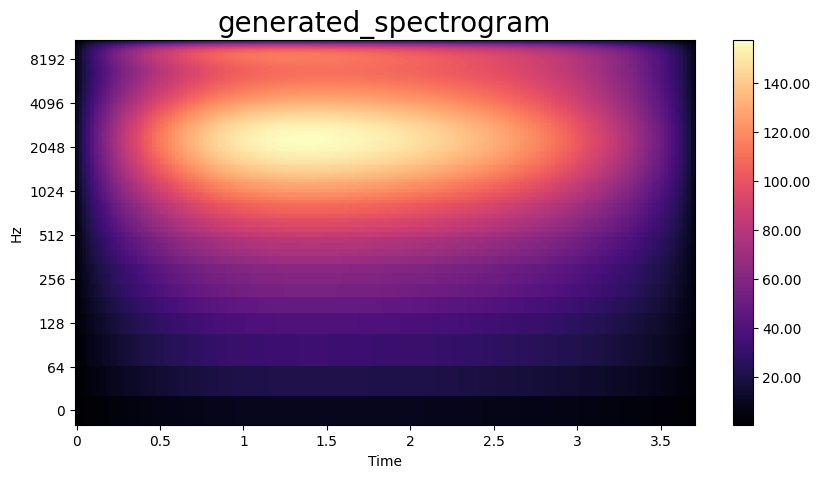

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='log')
plt.title('generated_spectrogram', fontsize=20)
plt.colorbar(img, format='%0.2f')

plt.show()

In [37]:
audio = librosa.feature.inverse.mel_to_audio(spectrogram)

path = '../models/generated_samples/'
file_name = 'PGAN_generated_audio.wav'

sf.write(path + file_name, audio, 22050)